In [1]:
import sys
sys.path.append("..")
import feature_engineer as fe
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

2023-07-29 23:04:53.934696: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 23:04:53.998395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 23:04:53.999113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 23:04:54.750383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
with open('../data/dataset_df.pkl', 'rb') as file:
    dataset_df = pickle.load(file)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [3]:
# Load the labels
with open('../data/labels.pkl', 'rb') as file:
    labels = pickle.load(file)
print("Full train label shape is {}".format(labels.shape))

Full train label shape is (424116, 4)


In [4]:
# Process the dataset
dataset_df = fe.feature_engineer1(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 23)


In [5]:
# Define the features and all users
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = dataset_df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 22 features
We will train with 23562 users info


In [6]:
# Build the model
def build_model():
    input_layer = Input(shape=(dataset_df.shape[1] - 1,))
    hidden_layer_1 = Dense(64, activation='relu')(input_layer)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer_1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [7]:
# Train the model
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# KFold
for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('### Fold',i+1)

    # Train with 18 questions
    for t in range(1,19):
        print(t,', ',end='')
        
        # Match the level group
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # Split the dataset
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==t].set_index('session').loc[valid_users]

        label_encoder = LabelEncoder()
        train_y_encoded = label_encoder.fit_transform(train_y['correct'])
        valid_y_encoded = label_encoder.transform(valid_y['correct'])

        # Train
        clf = build_model()
        early = EarlyStopping(monitor="val_loss", mode= "min", patience=7)
        callbacks_list = [early]
        clf.compile(optimizer=Adam(learning_rate=0.05), loss='binary_crossentropy',metrics=['accuracy'])
        clf.fit(train_x[FEATURES].astype('float32'), train_y_encoded,
                  validation_data=(valid_x[FEATURES].astype('float32'), valid_y_encoded),
                  epochs=5,callbacks= callbacks_list)
        
        # Save models and predictions
        models[f'{grp}_{t}'] = clf 
        oof.loc[valid_users, t - 1] = clf.predict(valid_x[FEATURES].astype('float32'))[:, 0]

### Fold 1
1 , Epoch 1/5


2023-07-29 23:05:26.086264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 23:05:26.087252: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


590/590 [==============================] - 1s 2ms/step - loss: 1112.5631 - accuracy: 0.7125 - val_loss: 0.5944 - val_accuracy: 0.7187
Epoch 2/5
590/590 [==============================] - 1s 1ms/step - loss: 0.5849 - accuracy: 0.7296 - val_loss: 0.5942 - val_accuracy: 0.7187
Epoch 3/5
590/590 [==============================] - 1s 1ms/step - loss: 0.5844 - accuracy: 0.7297 - val_loss: 0.5971 - val_accuracy: 0.7187
Epoch 4/5
590/590 [==============================] - 1s 1ms/step - loss: 0.5845 - accuracy: 0.7297 - val_loss: 0.5943 - val_accuracy: 0.7187
Epoch 5/5
148/148 [==============================] - 0s 763us/step
2 , Epoch 1/5
590/590 [==============================] - 1s 1ms/step - loss: 4759.8008 - accuracy: 0.9467 - val_loss: 3.1075 - val_accuracy: 0.9762
Epoch 2/5
590/590 [==============================] - 1s 1ms/step - loss: 1378.7841 - accuracy: 0.9793 - val_loss: 500.8581 - val_accuracy: 0.9764
Epoch 3/5
590/590 [==============================] - 1s 1ms/step - loss: 0.3563 - 

In [8]:
# Save the models in pickle
with open("../data/MLP_FE1_models.pkl", "wb") as f:
    pickle.dump(models, f)
oof.to_csv("../data/MLP_FE1_predictions.csv", index=True)

In [9]:
# Find the true labels
true = oof.copy()
for k in range(18):
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [10]:
# Find the best threshold
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

print("Best threshold ", best_threshold, "\tF1 score ", best_score)

Best threshold  0.6500000000000002 	F1 score  0.6497436504332017


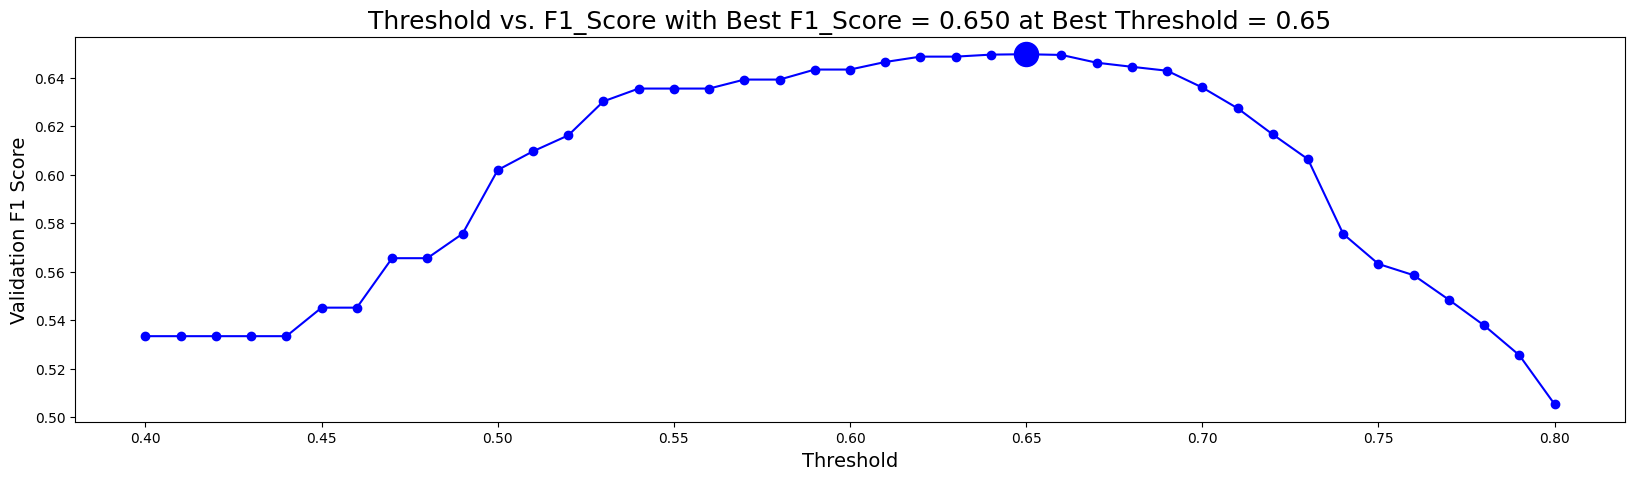

In [11]:
# Plot the scores with thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [12]:
# Print the scores
print('When using optimal threshold...')
for k in range(18): 
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)

m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.42109530478366625
Q1: F1 = 0.49463795470144134
Q2: F1 = 0.4829379622111523
Q3: F1 = 0.4438989851309889
Q4: F1 = 0.31125998101876806
Q5: F1 = 0.43692197395148763
Q6: F1 = 0.42398239823982403
Q7: F1 = 0.27681777723212914
Q8: F1 = 0.4240387200860446
Q9: F1 = 0.3313387131872666
Q10: F1 = 0.4995071067331541
Q11: F1 = 0.4632068164213788
Q12: F1 = 0.42040521003852005
Q13: F1 = 0.4144050104384134
Q14: F1 = 0.3417390472191015
Q15: F1 = 0.4235737351991388
Q16: F1 = 0.4074986798098926
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.6497436504332017
